<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Income_fluctuation_problem_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
from numba import njit, prange, vectorize, float64, jitclass, int32
from interpolation import mlinterp, interp
from math import gamma
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import scipy.optimize as op
from scipy.stats import cumfreq, beta

## Method 1

In [3]:
js_data=[('beta', float64),
     ('c', float64),
     ('w_grids', float64[:]),
     ('pi_grids', float64[:]),
     ('F_draws', float64[:]),
     ('G_draws', float64[:]),
     ('F_a', float64),
     ('F_b', float64),
     ('G_a', float64),
     ('G_b', float64),
     ('mc_size', int32)
    ]

@jitclass(js_data)
class JSLearningModel:
  def __init__(self,beta=0.95,
            c=0.3,
            F_a=1.0, 
            F_b=1.0,
            G_a=3.0,
            G_b=1.2,
            mc_size=500,
            w_max=1,
            grid_size=100,
            seed=1234):
    
    self.beta, self.c = beta, c
    self.F_a, self.F_b, self.G_a, self.G_b = F_a, F_b, G_a, G_b
    self.mc_size = mc_size
    self.w_grids = np.linspace(0, w_max, grid_size)
    self.pi_grids = np.linspace(1e-3, 1-1e-3, grid_size)
  
    np.random.seed(seed)
    self.F_draws = np.random.beta(F_a, F_b, size=mc_size)
    self.G_draws = np.random.beta(G_a, G_b, size=mc_size)


@vectorize
def p(x, a, b):
  r = gamma(a + b) / (gamma(a) * gamma(b))
  return r * x**(a-1) * (1 - x)**(b-1)

@njit
def compute_weight(w, pi, jsl):
  F_a, F_b, G_a, G_b = jsl.F_a, jsl.F_b, jsl.G_a, jsl.G_b
  num = pi*p(w, F_a, F_b)
  den = num + (1 - pi)*p(w, G_a, G_b)
  return num/den

@njit(parallel=True)
def state_action_value(w, pi, v, jsl):
  beta, c = jsl.beta, jsl.c
  w_grids, pi_grids = jsl.w_grids, jsl.pi_grids
  mc_size, F_draws, G_draws = jsl.mc_size, jsl.F_draws, jsl.G_draws

  def V(w, pi):
    return mlinterp((w_grids, pi_grids), v, (w, pi))

  integralf, integralg = 0, 0
  for i in prange(mc_size):
    integralf += V(F_draws[i], compute_weight(F_draws[i], pi, jsl))
    integralg += V(G_draws[i], compute_weight(G_draws[i], pi, jsl))
  integral = (pi*integralf + (1-pi)*integralg)/mc_size

  return max(w/(1-beta), c+beta*integral)


@njit
def T(v, jsl):
  w_grids, pi_grids = jsl.w_grids, jsl.pi_grids
  Tv = np.empty_like(v)
  for i in range(len(w_grids)):
    for j in range(len(pi_grids)):
      w, pi = w_grids[i], pi_grids[j] 
      Tv[i, j] = state_action_value(w, pi, v, jsl)
  return Tv


def compute_value_function(jsl, max_iter=1000, tol=1e-4, verbose=True, print_skip=5):
  v = np.zeros((len(jsl.w_grids), len(jsl.pi_grids))) + 10

  i = 0
  err = 1 + tol
  while i < max_iter and err > tol:
    Tv = T(v, jsl)
    i += 1
    err = np.max(np.abs(Tv - v))
    v = Tv
    if verbose and i%print_skip==0:
      print(f'Error is {err} at interation {i}.')
    
  if i == max_iter:
    raise RuntimeError('Iteration failed.')
  
  if verbose:
    print(f'\nConverged on interation {i}!')

  return v

@njit
def policy(v, jsl):
  sigma = np.empty_like(v)
  for i, w in enumerate(jsl.w_grids):
    v1 = w/(1-jsl.beta)
    for j, pi in enumerate(jsl.pi_grids):
      v2 = state_action_value(w, pi, v, jsl)
      sigma[i, j] = 1 if v1 >= v2 else 0
  return sigma

In [4]:
%%time

jsl = JSLearningModel()
v = compute_value_function(jsl)

Error is 0.4615731148518005 at interation 5.
Error is 0.07536687871352044 at interation 10.
Error is 0.014922773848509152 at interation 15.
Error is 0.0030796441720983836 at interation 20.
Error is 0.0006357929845268728 at interation 25.
Error is 0.00013126401980478875 at interation 30.

Converged on interation 31!
CPU times: user 4min 28s, sys: 9.49 s, total: 4min 38s
Wall time: 2min 31s


CPU times: user 65.1 ms, sys: 14.2 ms, total: 79.3 ms
Wall time: 73.1 ms


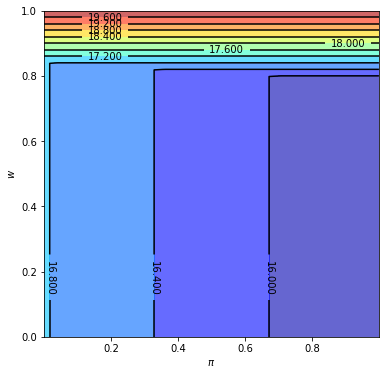

In [5]:
%%time 

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(jsl.pi_grids, jsl.w_grids, v, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(jsl.pi_grids, jsl.w_grids, v, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel='$\pi$', ylabel='$w$');

In [6]:
%%time

sigma = policy(v, jsl)

CPU times: user 8.82 s, sys: 274 ms, total: 9.09 s
Wall time: 5.04 s


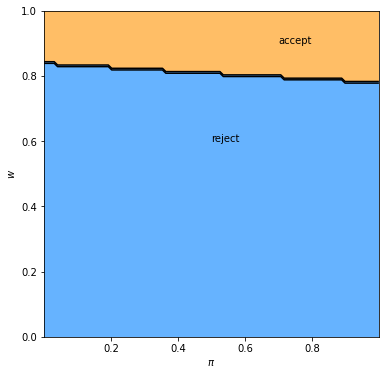

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(jsl.pi_grids, jsl.w_grids, sigma, 1, alpha=0.6, cmap=cm.jet)
ax.contour(jsl.pi_grids, jsl.w_grids, sigma, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept');

## Method 2

In [8]:
@njit(parallel=True)
def state_action_value2(pi, w, jsl):
  c, beta = jsl.c, jsl.beta
  mc_size, F_draws, G_draws = jsl.mc_size, jsl.F_draws, jsl.G_draws
  pi_grids = jsl.pi_grids

  W = lambda pi_: interp(pi_grids, w, pi_)
  expected = 0

  integralf = integralg = 0
  for i in prange(mc_size):
    integralf += max(F_draws[i]/(1-beta), W(compute_weight(F_draws[i], pi, jsl))/(1-beta))
    integralg += max(G_draws[i]/(1-beta), W(compute_weight(G_draws[i], pi, jsl))/(1-beta))
  integral = (pi*integralf + (1-pi)*integralg)/mc_size
  return c*(1-beta)+beta*(1-beta)*integral

@njit
def K(w, jsl):
  pi_grids = jsl.pi_grids
  Kw = np.empty_like(w)
  for i, pi in enumerate(pi_grids):
    Kw[i] = state_action_value2(pi, w, jsl)
  return Kw

def compute_policy(jsl, max_iter=1000, tol=1e-4, verbose=True, print_skip=25):
  w = np.copy(jsl.pi_grids)/(1-jsl.beta)
  i = 0
  err = 1+tol
  while i < max_iter and err>tol:
    Kw = K(w, jsl)
    i += 1
    err = np.max(np.abs(Kw-w))
    w = Kw
    if verbose and i%print_skip==0:
      print(f"Error is {err} on interation {i}.")
  
  if i == max_iter:
    raise RuntimeError('Iteration failed!')
  
  if verbose:
    print(f'\nConverged on interation {i}!')
  
  return w

@njit
def compute_action(w, jsl):
  w_grids, pi_grids = jsl.w_grids, jsl.pi_grids
  beta = jsl.beta
  action = np.empty((len(w_grids), len(pi_grids)))
  w_bar = lambda pi: interp(pi_grids, w, pi)
  for i, w_val in enumerate(w_grids):
    for j, pi_val in enumerate(pi_grids):
      action[i, j] = 1 if w_val > w_bar(pi_val) else 0
  return action

In [9]:
%%time
jsl2 = JSLearningModel()
sigma_policy = compute_policy(jsl2)

Error is 0.28667623207530113 on interation 25.
Error is 0.07886779263553345 on interation 50.
Error is 0.005563929784597299 on interation 75.

Converged on interation 88!
CPU times: user 8.18 s, sys: 245 ms, total: 8.42 s
Wall time: 5.68 s


In [10]:
%%time
policy2 = compute_action(sigma_policy, jsl2)

CPU times: user 220 ms, sys: 2.97 ms, total: 223 ms
Wall time: 223 ms


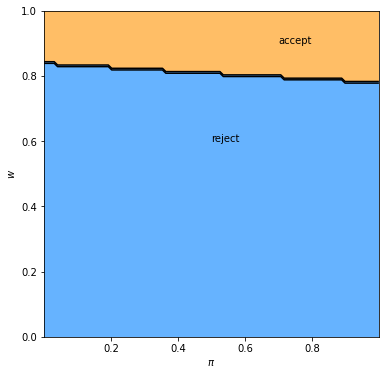

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(jsl2.pi_grids, jsl2.w_grids, policy2, 1, alpha=0.6, cmap=cm.jet)
ax.contour(jsl2.pi_grids, jsl2.w_grids, policy2, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept');